## <center> Time Series Models with Multiple Linear Regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

<a id="acs"></a>

In [131]:
df = pd.read_csv('australia_drug_sales.csv',index_col=0)
df.head()

,time,value
1,1991.500000,0.429795
2,1991.583333,0.400906
3,1991.666667,0.432159
4,1991.750000,0.492543
5,1991.833333,0.502369


In [132]:
df['time'].mod(1)

1      0.500000
2      0.583333
3      0.666667
4      0.750000
5      0.833333
         ...   
200    0.083333
201    0.166667
202    0.250000
203    0.333333
204    0.416667
Name: time, Length: 204, dtype: float64

In [133]:
(df['time'].mod(1)*12)+1

1       7.0
2       8.0
3       9.0
4      10.0
5      11.0
       ... 
200     2.0
201     3.0
202     4.0
203     5.0
204     6.0
Name: time, Length: 204, dtype: float64

<a id="settimeseries"></a>

In [ ]:
df['month'] = ((df['time'].mod(1)*12)+1).round(0).astype(int)
df['year'] = df['time'].astype(int)
df['day'] = np.ones(len(df))
df.head()

In [135]:
df['date'] = pd.to_datetime(df[['year','month','day']])
df.index = pd.DatetimeIndex(df['date'])
df.drop(['time', 'month', 'year', 'day', 'date'],axis=1,inplace=True)
df.head()

,value
date,
1991-07-01,0.429795
1991-08-01,0.400906
1991-09-01,0.432159
1991-10-01,0.492543
1991-11-01,0.502369


<a id="exploretimeseries"></a>

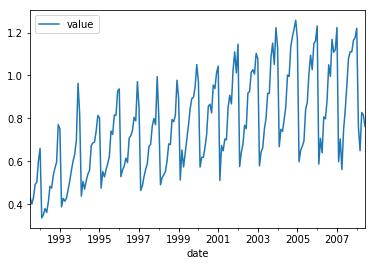

In [136]:
df.plot()

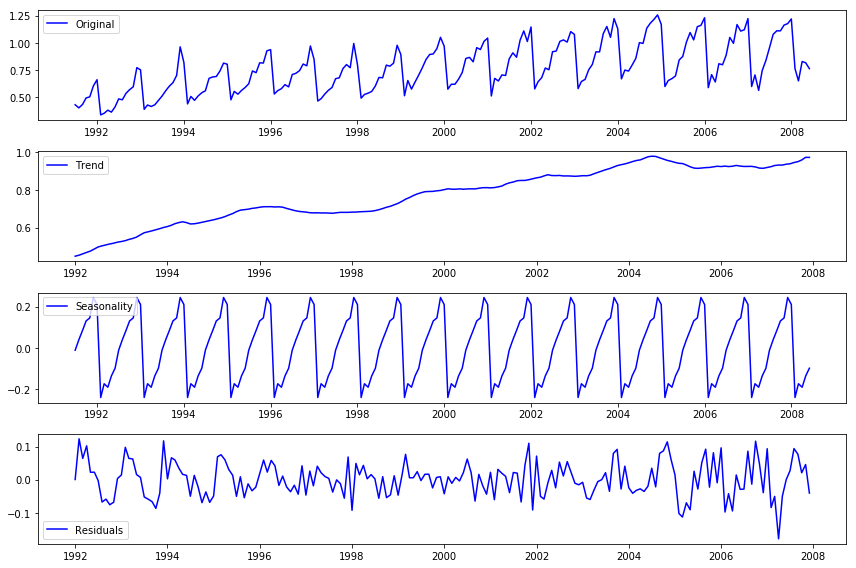

In [37]:
# Import and apply seasonal_decompose()
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df)
# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df, label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

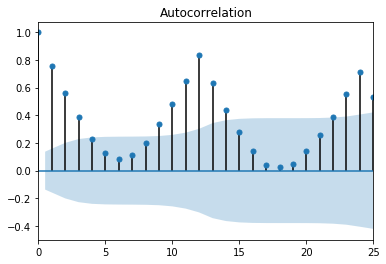

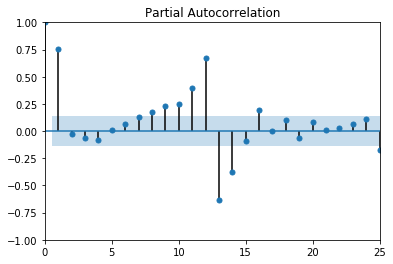

In [60]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df,lags=25); plt.xlim(0,25); plt.show()
plot_pacf(df,lags=25); plt.xlim(0,25); plt.ylim(-1,1);plt.show()

<a id="autoarima"></a>

In [8]:
from pmdarima.arima import auto_arima
test_period = 6*12
arima = auto_arima(df['value'][:-test_period], trace=True, error_action='ignore', suppress_warnings=True, seasonal=True, m=12)

Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 1, 1, 12); AIC=-382.382, BIC=-360.082, Fit time=2.892 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=-343.908, BIC=-338.333, Fit time=0.092 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=-364.562, BIC=-353.412, Fit time=0.495 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=-355.969, BIC=-344.819, Fit time=0.534 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=-294.623, BIC=-291.835, Fit time=0.036 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 1, 1, 12); AIC=-381.325, BIC=-361.812, Fit time=1.819 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 1, 0, 12); AIC=-378.752, BIC=-359.239, Fit time=1.698 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(2, 1, 1, 12); AIC=-382.976, BIC=-357.889, Fit time=4.406 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(2, 1, 0, 12); AIC=-382.720, BIC=-360.421, Fit time=4.572 seconds
Fit ARIMA: order=(2, 0, 2) s

In [39]:
arima_forecast = arima.predict(n_periods=test_period)

In [40]:
from sklearn.metrics import mean_squared_error
mean_squared_error(df['value'][-test_period:], arima_forecast)

0.01318340623773266

### <center> Generating Features
<a id="regressionfeatures"></a>

- DateTime components (Year, Month, Day)
- Previous values (Yesterday's value, last week's value, etc.)
- Polynomial terms (Squared and cubed previous values)
- Interaction terms (Yesterday's value times last week's value)

In [137]:
## Add year and month features
df['Year'] = df.index.year - np.min(df.index.year)
df['Month'] = df.index.month
date_features = ['Year', 'Month']
df.head()

,value,Year,Month
date,,,
1991-07-01,0.429795,0,7
1991-08-01,0.400906,0,8
1991-09-01,0.432159,0,9
1991-10-01,0.492543,0,10
1991-11-01,0.502369,0,11


In [138]:
## Add polynomials of datetime components
polynomial_terms = [2,3]
for feature in date_features:
    for i in polynomial_terms:
        df[feature+'**'+str(i)] = df[feature]**i
df.head()

,value,Year,Month,Year**2,Year**3,Month**2,Month**3
date,,,,,,,
1991-07-01,0.429795,0,7,0,0,49,343
1991-08-01,0.400906,0,8,0,0,64,512
1991-09-01,0.432159,0,9,0,0,81,729
1991-10-01,0.492543,0,10,0,0,100,1000
1991-11-01,0.502369,0,11,0,0,121,1331


In [139]:
## Add previous values and polynomial terms of previous values
previous_values_range = 10*12
for i in range(1,previous_values_range):
    df['Previous'+str(i)] = df['value'].shift(i).bfill()
    for j in polynomial_terms:
        df['Previous'+str(i)+'**'+str(j)] = (df['value'].shift(i).bfill())**j
df.head()

,value,Year,Month,Year**2,Year**3,Month**2,Month**3,Previous1,Previous1**2,Previous1**3,...,Previous116**3,Previous117,Previous117**2,Previous117**3,Previous118,Previous118**2,Previous118**3,Previous119,Previous119**2,Previous119**3
date,,,,,,,,,,,,,,,,,,,,,
1991-07-01,0.429795,0,7,0,0,49,343,0.429795,0.184724,0.079393,...,0.079393,0.429795,0.184724,0.079393,0.429795,0.184724,0.079393,0.429795,0.184724,0.079393
1991-08-01,0.400906,0,8,0,0,64,512,0.429795,0.184724,0.079393,...,0.079393,0.429795,0.184724,0.079393,0.429795,0.184724,0.079393,0.429795,0.184724,0.079393
1991-09-01,0.432159,0,9,0,0,81,729,0.400906,0.160726,0.064436,...,0.079393,0.429795,0.184724,0.079393,0.429795,0.184724,0.079393,0.429795,0.184724,0.079393
1991-10-01,0.492543,0,10,0,0,100,1000,0.432159,0.186761,0.080711,...,0.079393,0.429795,0.184724,0.079393,0.429795,0.184724,0.079393,0.429795,0.184724,0.079393
1991-11-01,0.502369,0,11,0,0,121,1331,0.492543,0.242599,0.119490,...,0.079393,0.429795,0.184724,0.079393,0.429795,0.184724,0.079393,0.429795,0.184724,0.079393


<a id="lassomodel"></a>

In [143]:
## fit lasso regression
from sklearn.linear_model import LassoLarsCV
reg = LassoLarsCV(cv=5).fit(df.drop('value',axis=1)[:-test_period], df['value'][:-test_period])

In [149]:
## view features selected
selected_features = pd.DataFrame()
selected_features['Feature'] = df.drop('value',axis=1).columns[reg.coef_>0]
selected_features['Coefficient'] = reg.coef_[reg.coef_>0]
selected_features

,Feature,Coefficient
0,Month**3,0.000017
1,Previous1,0.039885
2,Previous12,0.790782
3,Previous48,0.021406
4,Previous70**3,0.001545
5,Previous72,0.056554


<a id="forecasting"></a>

In [150]:
## create and populate forecast dataframe
forecast_df = df.copy()
for datetime, date in zip(df.index[-test_period:], range(len(df)-test_period, len(df))):
    values = []
    ## add datetime components
    values.append(datetime.year - np.min(df.index.year))
    values.append(datetime.month)
    ## add polynomial terms of datetime components
    for feature in date_features:
        for i in polynomial_terms:
            values.append((forecast_df[feature][date])**i)
    ## add previous values and polynomial terms of previous values
    for i in range(1,previous_values_range):
        values.append(forecast_df['value'][date-i])
        for j in polynomial_terms:
            values.append((forecast_df['value'][date-i])**j)
    ## make prediction on current datetime
    forecast = reg.predict(np.array(values).reshape(1,-1))
    ## append prediction to start of values array
    values.insert(0, forecast[0])
    ## set forecast row in dataframe
    forecast_df.loc[datetime] = values

<a id="comparison"></a>

In [151]:
print('ARIMA MSE:', mean_squared_error(df['value'][-test_period:], arima_forecast))
print('Regression MSE:', mean_squared_error(df['value'][-test_period:], forecast_df['value'][-test_period:]))

ARIMA MSE: 0.01318340623773266
Regression MSE: 0.00872357960100832


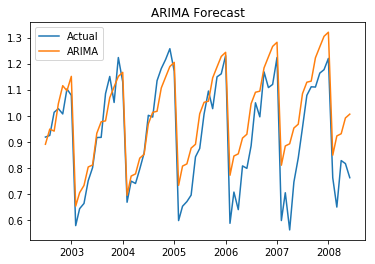

In [152]:
plt.plot(df.index[-test_period:], df['value'][-test_period:])
plt.plot(df.index[-test_period:], arima_forecast)
plt.title('ARIMA Forecast')
plt.legend(['Actual', 'ARIMA'])

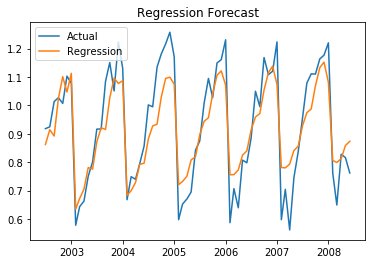

In [153]:
plt.plot(df.index[-test_period:], df['value'][-test_period:])
plt.plot(df.index[-test_period:], forecast_df['value'][-test_period:])
plt.title('Regression Forecast')
plt.legend(['Actual', 'Regression'])

## <center> Residuals

Text(0.5, 1.0, 'ARIMA Residuals')

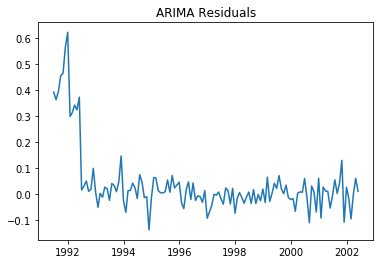

In [158]:
plt.plot(df.index[:-test_period], arima.resid())
plt.title('ARIMA Residuals')

Text(0.5, 1.0, 'Regression Residuals')

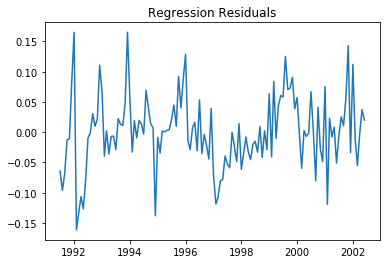

In [159]:
regression_resid = df['value'][:-test_period]-reg.predict(df.drop('value',axis=1)[:-test_period])
plt.plot(regression_resid)
plt.title('Regression Residuals')

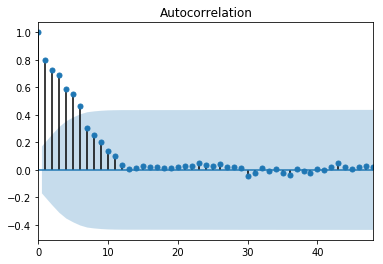

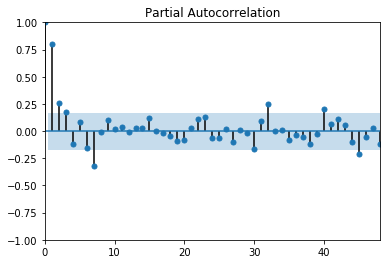

In [160]:
## ACF and PACF of residuals
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(arima.resid(),lags=48); plt.xlim(0,48); plt.show()
plot_pacf(arima.resid(),lags=48); plt.xlim(0,48); plt.ylim(-1,1);plt.show()

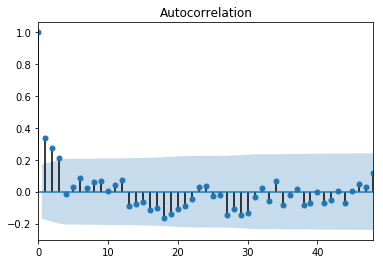

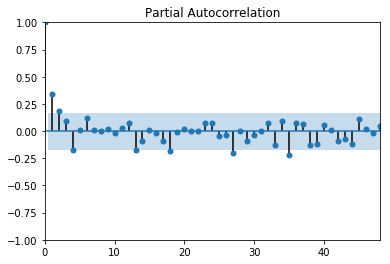

In [161]:
plot_acf(regression_resid,lags=48); plt.xlim(0,48); plt.show()
plot_pacf(regression_resid,lags=48); plt.xlim(0,48); plt.ylim(-1,1);plt.show()

### <center> Another example

<a id="loaddata2"></a>

In [330]:
sunspots_df = pd.read_csv('Sunspots.csv')
sunspots_df.head()

,Month,Sunspots
0,1749-01,58.0
1,1749-02,62.6
2,1749-03,70.0
3,1749-04,55.7
4,1749-05,85.0


<a id="settimeseries2"></a>

In [331]:
sunspots_df.index = pd.DatetimeIndex(sunspots_df['Month'])
sunspots_df.drop('Month', axis=1, inplace=True)
sunspots_df.head()

,Sunspots
Month,
1749-01-01,58.0
1749-02-01,62.6
1749-03-01,70.0
1749-04-01,55.7
1749-05-01,85.0


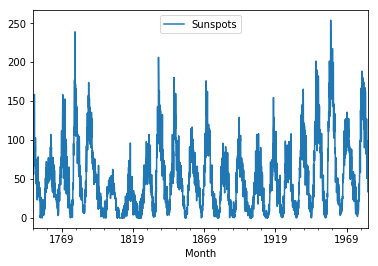

In [332]:
sunspots_df.plot()

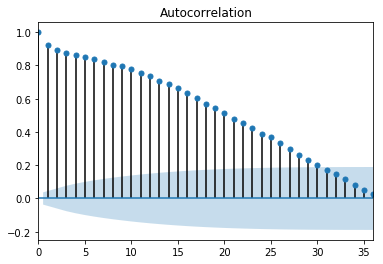

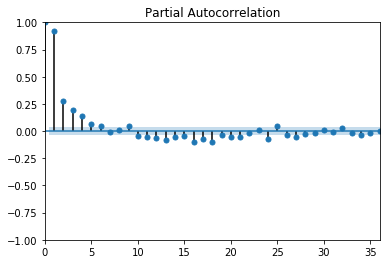

In [268]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
lags = 36
plot_acf(sunspots_df,lags=lags); plt.xlim(0,lags); plt.show()
plot_pacf(sunspots_df,lags=lags); plt.xlim(0,lags); plt.ylim(-1,1);plt.show()

<a id="autoarima2"></a>

In [308]:
arima = auto_arima(sunspots_df['Sunspots'][:-test_period], trace=True, error_action='ignore', suppress_warnings=True, seasonal=True, m=12)

Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 1, 12); AIC=21464.630, BIC=21511.472, Fit time=11.533 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=21952.007, BIC=21963.718, Fit time=0.058 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 12); AIC=21709.161, BIC=21732.582, Fit time=0.587 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 12); AIC=21560.722, BIC=21584.142, Fit time=1.577 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=21950.010, BIC=21955.865, Fit time=0.036 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 1, 12); AIC=21463.324, BIC=21504.310, Fit time=7.425 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 12); AIC=21461.705, BIC=21496.836, Fit time=2.754 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 0, 12); AIC=21463.368, BIC=21504.355, Fit time=9.313 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 12); AIC=21525.096, BIC=21554.372, Fit time=0.830 seconds
Fit ARIMA

In [314]:
arima_forecast = arima.predict(n_periods=test_period)

<a id="regressionfeatures2"></a>

In [269]:
sunspots_df['Year'] = sunspots_df.index.year - np.min(sunspots_df.index.year)
sunspots_df['Month'] = sunspots_df.index.month
date_features = ['Year', 'Month']
sunspots_df.head()

,Sunspots,Year,Month
Month,,,
1749-01-01,58.0,0,1
1749-02-01,62.6,0,2
1749-03-01,70.0,0,3
1749-04-01,55.7,0,4
1749-05-01,85.0,0,5


In [270]:
## Add polynomials of datetime components
polynomial_terms = [2,3]
for feature in date_features:
    for i in polynomial_terms:
        sunspots_df[feature+'**'+str(i)] = sunspots_df[feature]**i
sunspots_df.head()

,Sunspots,Year,Month,Year**2,Year**3,Month**2,Month**3
Month,,,,,,,
1749-01-01,58.0,0,1,0,0,1,1
1749-02-01,62.6,0,2,0,0,4,8
1749-03-01,70.0,0,3,0,0,9,27
1749-04-01,55.7,0,4,0,0,16,64
1749-05-01,85.0,0,5,0,0,25,125


In [271]:
## Add previous values and polynomial terms of previous values
previous_values_range = 10*12
for i in range(1,previous_values_range):
    sunspots_df['Previous'+str(i)] = sunspots_df['Sunspots'].shift(i).bfill()
    for j in polynomial_terms:
        sunspots_df['Previous'+str(i)+'**'+str(j)] = (sunspots_df['Sunspots'].shift(i).bfill())**j
sunspots_df.head()

,Sunspots,Year,Month,Year**2,Year**3,Month**2,Month**3,Previous1,Previous1**2,Previous1**3,...,Previous116**3,Previous117,Previous117**2,Previous117**3,Previous118,Previous118**2,Previous118**3,Previous119,Previous119**2,Previous119**3
Month,,,,,,,,,,,,,,,,,,,,,
1749-01-01,58.0,0,1,0,0,1,1,58.0,3364.00,195112.000,...,195112.0,58.0,3364.0,195112.0,58.0,3364.0,195112.0,58.0,3364.0,195112.0
1749-02-01,62.6,0,2,0,0,4,8,58.0,3364.00,195112.000,...,195112.0,58.0,3364.0,195112.0,58.0,3364.0,195112.0,58.0,3364.0,195112.0
1749-03-01,70.0,0,3,0,0,9,27,62.6,3918.76,245314.376,...,195112.0,58.0,3364.0,195112.0,58.0,3364.0,195112.0,58.0,3364.0,195112.0
1749-04-01,55.7,0,4,0,0,16,64,70.0,4900.00,343000.000,...,195112.0,58.0,3364.0,195112.0,58.0,3364.0,195112.0,58.0,3364.0,195112.0
1749-05-01,85.0,0,5,0,0,25,125,55.7,3102.49,172808.693,...,195112.0,58.0,3364.0,195112.0,58.0,3364.0,195112.0,58.0,3364.0,195112.0


<a id="lassomodel2"></a>

In [272]:
## fit lasso regression
from sklearn.linear_model import LassoLarsCV
test_period = 20*12
reg = LassoLarsCV(cv=10).fit(sunspots_df.drop('Sunspots',axis=1)[:-test_period], sunspots_df['Sunspots'][:-test_period])

In [ ]:
## view features selected
selected_features = pd.DataFrame()
selected_features['Feature'] = sunspots_df.drop('Sunspots',axis=1).columns[reg.coef_>0]
selected_features['Coefficient'] = reg.coef_[reg.coef_>0]
selected_features.sort_values('Coefficient')

<a id="forecasting2"></a>

In [274]:
## create and populate forecast dataframe
forecast_df = sunspots_df.copy()
for datetime, date in zip(sunspots_df.index[-test_period:], range(len(sunspots_df)-test_period, len(sunspots_df))):
    values = []
    ## add datetime components
    values.append(datetime.year - np.min(sunspots_df.index.year))
    values.append(datetime.month)
    ## add polynomial terms of datetime components
    for feature in date_features:
        for i in polynomial_terms:
            values.append((forecast_df[feature][date])**i)
    ## add previous values and polynomial terms of previous values
    for i in range(1,previous_values_range):
        values.append(forecast_df['Sunspots'][date-i])
        for j in polynomial_terms:
            values.append((forecast_df['Sunspots'][date-i])**j)
    ## make prediction on current datetime
    forecast = reg.predict(np.array(values).reshape(1,-1))
    ## append prediction to start of values array
    values.insert(0, forecast[0])
    ## set forecast row in dataframe
    forecast_df.loc[datetime] = values

<a id="comparison2"></a>

In [311]:
print('ARIMA MSE:', mean_squared_error(sunspots_df['Sunspots'][-test_period:], arima_forecast))
print('Regression MSE:', mean_squared_error(sunspots_df['Sunspots'][-test_period:], forecast_df['Sunspots'][-test_period:]))

ARIMA MSE: 5275.570612881323
Regression MSE: 3792.7145995561955


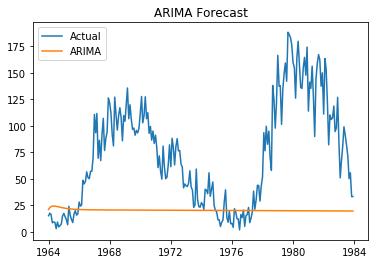

In [316]:
plt.plot(sunspots_df.index[-test_period:], sunspots_df['Sunspots'][-test_period:])
plt.plot(sunspots_df.index[-test_period:], arima_forecast)
plt.title('ARIMA Forecast')
plt.legend(['Actual', 'ARIMA'])

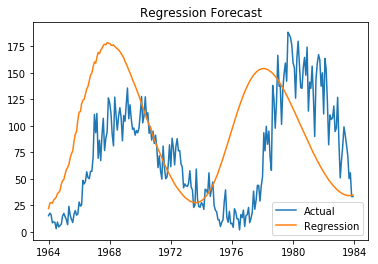

In [315]:
plt.plot(sunspots_df.index[-test_period:], sunspots_df['Sunspots'][-test_period:])
plt.plot(sunspots_df.index[-test_period:], forecast_df['Sunspots'][-test_period:])
plt.title('Regression Forecast')
plt.legend(['Actual', 'Regression'])

Text(0.5, 1.0, 'ARIMA Residuals')

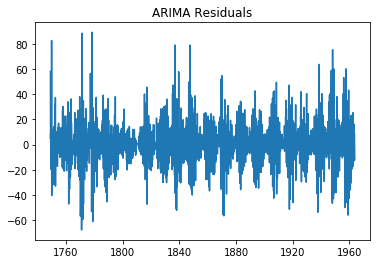

In [321]:
plt.plot(sunspots_df.index[:-test_period], arima.resid())
plt.title('ARIMA Residuals')

Text(0.5, 1.0, 'Regression Residuals')

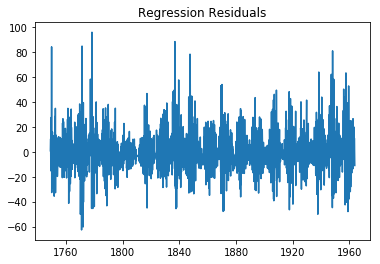

In [322]:
regression_resid = sunspots_df['Sunspots'][:-test_period]-reg.predict(sunspots_df.drop('Sunspots',axis=1)[:-test_period])
plt.plot(regression_resid)
plt.title('Regression Residuals')

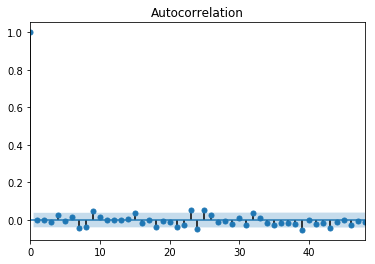

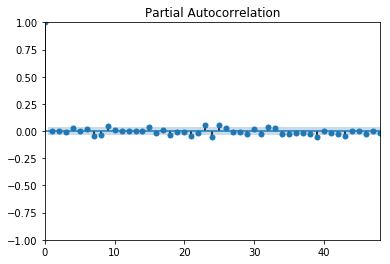

In [325]:
lags = 48  ## ARIMA
plot_acf(arima.resid(),lags=lags); plt.xlim(0,lags); plt.show()
plot_pacf(arima.resid(),lags=lags); plt.xlim(0,lags); plt.ylim(-1,1);plt.show()

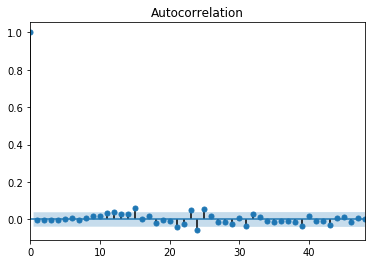

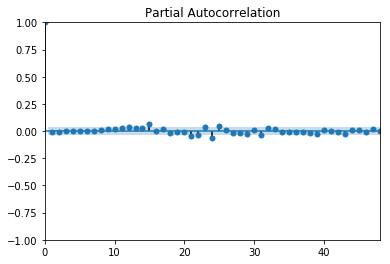

In [324]:
lags = 48 ## Regression
plot_acf(regression_resid,lags=lags); plt.xlim(0,lags); plt.show()
plot_pacf(regression_resid,lags=lags); plt.xlim(0,lags); plt.ylim(-1,1);plt.show()

## <center> Activity

Using the data in <i>stock_data.csv</i>, your goal is to suggest the best stock for investment in order to make the biggest return if sold tomorrow. <br> <br>
Use only the 'Close' data to build time series models for each stock using linear regression.<br><br>
Use the most recent year of data to test your models on. <br> <br>

1) Store seperate dataframes for each stock in a list.<br><br>
2) For each dataframe in the list, generate features from the datetime data.<br><br>
3) Build a LassoLars model for each stock.<br><br>
4) For each stock, forecast each date in the test data in a stepwise fashion.<br><br>
5) Compare the predictions to the actual test data.<br><br>
<b>Bonus:</b> Determine the stock which is predicted to gain the most in value over the next day.

1. Australian Corticosteroid Sales <br>
    1.1 [Reading in data](#loaddata) <br>
    1.2 [Setting up time series](#settimeseries)<br>
    1.3 [Exploring time series](#exploretimeseries)<br>
    1.4 [Fitting auto-ARIMA](#autoarima)<br>
    1.5 [Generating regression features](#regressionfeatures)<br>
    1.6 [Fitting Lasso model](#lassomodel)<br>
    1.7 [Forecasting with regression model](#forecasting)<br>
    1.8 [Comparing ARIMA and regression](#comparison)<br>
1. Sunspots Data<br>
    1.1 [Reading in data](#loaddata2)<br>
    1.2 [Setting up time series](#settimeseries2)<br>
    1.3 [Exploring time series](#exploretimeseries2)<br>
    1.4 [Fitting auto-ARIMA](#autoarima2)<br>
    1.5 [Generating regression features](#regressionfeatures2)<br>
    1.6 [Fitting Lasso model](#lassomodel2)<br>
    1.7 [Forecasting with regression model](#forecasting2)<br>
    1.8 [Comparing ARIMA and regression](#comparison2)<br>

In [ ]:
## Create list of dataframes

In [ ]:
## Iterate through dataframes, performing feature generation and storing dataframe in new list

In [ ]:
## Fit a LassoLars regression model to each stock's data

In [ ]:
## For each model, iterate through the test dates, 
## calculating and generating values and forecasting the next value

In [ ]:
## Compare each model's predictions to true data

In [ ]:
## Predict next day stock values for each stock, determine the biggest increase in stock value